The data set I am using is a collection of Youtube comments with author name, date of posting comment and comment ID, that has been classified as either 'SPAM' or 'HAM' (1 or 0) under the CLASS colunm. The aim of my project is to find the optimum features of this data set to classify any comment in the same manner.

This model may come in handy while building apps (like a Chrome Extention), or mining data of the same kind from YouTube. 

### A note on the data set :

A preliminary exploration shows that there may be inherent bias. For example, conversations (i.e. spme sparky comments that set off a cascade of replies on the channel) seem to be missing, which are in reality a huge part of YouTube comments. 

This data set may not be an accurate representation of YouTube comments.

In [3]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import seaborn as sns


import sklearn.feature_extraction.text as sfe
import sklearn.naive_bayes

% matplotlib inline

In [4]:
path = r'YoutubeData/' # use your path
allFiles = glob.glob(path + "/*.csv")

frame = pd.DataFrame()

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

In [5]:
frame['Index'] = range(0, len(frame))
frame = frame.set_index('Index')
New = frame.copy()
New = New.sample( frac =1, random_state = 5)      

New = New.iloc[np.random.permutation(len(New))]
New = New.reset_index()
del New['Index']

Follwowing is the module that performs KFold cross-validation to test for the average performance of the 'text' feature on classification of data :

In [6]:
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

In [7]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()
classifier = sklearn.naive_bayes.MultinomialNB()
scores = []
confusion = np.array([[0, 0], [0, 0]])

In [8]:
for train, test in KFold(5).split(New) :
    
    train_data = New.iloc[train]['CONTENT'].values
    test_data = New.iloc[test]['CONTENT'].values
    
    spam_in_train = (New.iloc[train]['CLASS'] == 1)
    spam_in_test = (New.iloc[test]['CLASS'] == 1)
    
    vectorizer = sfe.CountVectorizer(stop_words = 'english')
    
    train_matrix = vectorizer.fit_transform(train_data)
    test_matrix = vectorizer.transform(test_data)
    
    classifier = sklearn.naive_bayes.MultinomialNB()
    classifier.fit(train_matrix, spam_in_train)
    
    predicted_spam = classifier.predict(test_matrix)
#    predicted_probs = classifier.predict_proba(test_matrix)
    accuracy = classifier.score(test_matrix, spam_in_test)

#    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(spam_in_test, predicted_spam)
    
    confusion = confusion_matrix(spam_in_test, predicted_spam)
    print(len(spam_in_test), len(predicted_spam), "\n", confusion)
    score = f1_score(spam_in_test, predicted_spam)
    scores.append(score)
    
print('Total comments classified:', len(New))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

392 392 
 [[169  30]
 [ 13 180]]
391 391 
 [[155  21]
 [  9 206]]
391 391 
 [[174  21]
 [ 13 183]]
391 391 
 [[167  26]
 [ 13 185]]
391 391 
 [[159  29]
 [ 16 187]]
Total comments classified: 1956
Score: 0.907534770745
Confusion matrix:
[[159  29]
 [ 16 187]]


Average performance of module using language vectorizer is 91%

The CountVectorizer() enriches its vocabulary using the words in the comments, which means that it learns garbage like '#@$fINMSG' and some various URLS independently. 

URLs in comments could be used as a separate estimator to improve classification accuracy.

#### To check whether any new information can be gleaned from the Date-Time stamp on each comment.

In [9]:
DT = pd.DataFrame(New[New.DATE.notnull()])
DT = DT.reset_index(drop = True)
DT['new_col'] = DT.DATE.apply(lambda x : parser.parse(x))
DT['date'] = [d.date() for d in DT.new_col]
DT['time'] = [d.time() for d in DT.new_col]

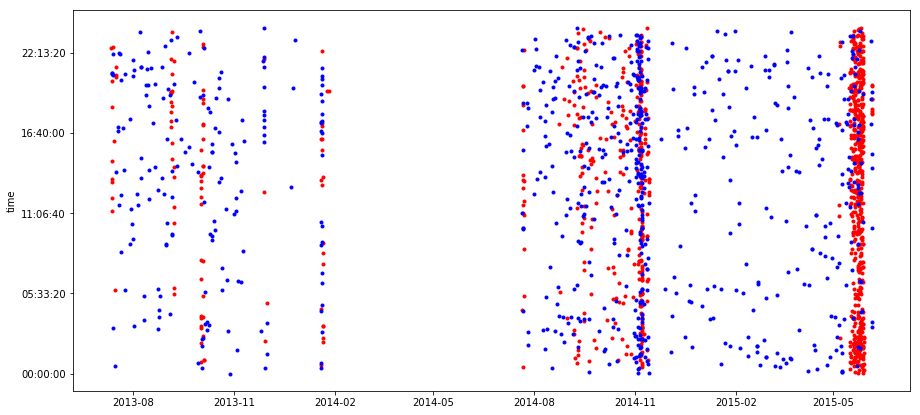

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
ax.plot(DT.date[DT.CLASS == 0], DT.time[DT.CLASS == 0], 'r.')
ax.plot(DT.date[DT.CLASS == 1], DT.time[DT.CLASS == 1], 'b.')
#plt.xlim('2015-05', '2015-07')                                    uncomment to zoom in on 2 months

As seen in the above, the spam comments (in blue) seem to be spread out over the dates, while the ham comments are concentrated usually over a period of around a two-weeks or less. However if you peek into the data set below, the close binning of ham comments is not due to any chain-reaction of replies to sparky comments. 

The data seems to have been chosen with some bias against replies, which implies that the Date-Time column is not a strong estimator for this data set.

In [11]:
New.sort_values('DATE')

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
1215,_2viQ_Qnc685RPw1aSa1tfrIuHXRvAQ2rPT9R06KTqA,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0
1414,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0
610,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0
750,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
1618,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0
488,_2viQ_Qnc6_1Hq9MGlefkBIszt9rYD3S_CozADvMhQ4,Dinova Sharon,2013-07-13T14:44:00.700000,well done shakira,0
653,_2viQ_Qnc689m-WiwOwvrQU7LvkLAgspnfXL8ovE0ME,TheHotChocolate,2013-07-13T18:26:37.017000,she is sooooo beautiful!,0
1860,_2viQ_Qnc68TufyXKiTwky80ewSPbhRiD5XFHrJH9lg,Ysobel Schofield,2013-07-13T20:17:25.181000,Waka waka she rules,0
692,_2viQ_Qnc6_RKHVetk9kLzx8ZC62_J7y73FWFSBTe8Q,ThirdDegr3e,2013-07-13T20:47:40.793000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
1701,_2viQ_Qnc69MEEHHJxZ427KX8MlljJPnUC2YBbvbWwY,ThirdDegr3e,2013-07-13T20:48:06.033000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
